# Istorpic features + practical procedure


In [ ]:
from sklearn.base import RegressorMixin
from scipy.stats import ortho_group # orthogonal matrix
from scipy.optimize import fsolve   # solve function

import numpy as np
import math

import os 
import json
import codecs

from joblib import Parallel, delayed

import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt 

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Sketched estimator

In [7]:
class SketchedRidgelessRegressor(RegressorMixin):
    """Sketched Ridgeless regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y, m, is_orthogonal=True):
        n = x.shape[0]
        p = x.shape[1]
        
        # Fixed S
        np.random.seed(1234)

        if is_orthogonal:
            S = ortho_group.rvs(dim=n)[0:m, :]  # orthogonal schetching matrix
        else:
            S = np.random.normal(size=(m, n), scale=1/np.sqrt(n))    # iid schetching matrix

        sx = np.matmul(S, x)
        sy = np.matmul(S, y)

        # xxinv = np.linalg.pinv(np.matmul(sx.T, sx))
        # xy = np.matmul(sx.T, sy)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(sx.T, sx)/n + 1e-6 * Ip)
        xy = np.matmul(sx.T, sy)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

In [8]:
class RidgelessLinearRegressor(RegressorMixin):
    """Ridgeless linear regression using Moore Penrose pseudoinverse."""

    def __init__(self):
        self.beta = None

    def fit(self, x, y):
        n = x.shape[0]
        p = x.shape[1]
        
        #xxinv = np.linalg.pinv(np.matmul(x.T, x))
        #xy = np.matmul(x.T, y)
        
        Ip = np.eye(p)
        xxinv = np.linalg.inv(np.matmul(x.T, x)/n + 1e-6 * Ip)
        xy = np.matmul(x.T, y)/n
        
        self.beta = np.matmul(xxinv, xy)
        return self

    def predict(self, x):
        return np.matmul(x, self.beta)

## Data generation

In [9]:
def gen_train_dat(n_train, n_features, alpha, sigma=1, seed=1234):
    """
    n_samples: n
    n_features: p
    alpha: beta's norm
    sigma: sigma
    """

    # seed for X 
    np.random.seed(1234)
    
    # Assumption 2.1 (model specification)
    x = np.random.normal(size=(n_train, n_features), scale=1)
    
    # seed for eps
    np.random.seed(seed+3524)
    
    # Assumption 2.2 (random beta)
    bet = alpha / np.sqrt(n_features) * np.random.normal(size=n_features) #from guassian prior
    
    eps = np.random.normal(size=n_train, scale=sigma)
    y = np.matmul(x, bet) + eps

    return x, y, bet

def gen_val_dat(n_val, n_features, beta, sigma=1, seed=1234):
        
    # seed for X 
    np.random.seed(3213)
    
    # Assumption 2.4 (correlated features)
    x = np.random.normal(size=(n_val, n_features), scale=1)
    
    # seed for eps
    np.random.seed(seed+1244)
    eps = np.random.normal(size=n_val, scale=sigma)
    y = np.matmul(x, beta) + eps

    return x, y

def gen_test_dat(n_test, n_features, beta, sigma=1, seed=1234):
    
    # seed for x0 and eps
    np.random.seed(seed+1234)
    
    x0 = np.random.normal(size=(n_test, n_features), scale=1)
    eps = np.random.normal(size=n_test, scale=sigma)
    y = np.matmul(x0, beta) + eps

    return x0, y

## Optimal m

In [10]:
def optimal_m(alpha, sigma, n_train, n_features):
    snr = alpha / sigma
    phi = n_features / n_train

    if snr > 1 and phi > (1 - sigma/(2*alpha)) and phi <= alpha/(alpha - sigma):
        opt_m = phi * n_train * (alpha - sigma) / alpha
        case = 1

    elif snr <= 1 and phi > (alpha**2 / (alpha**2 + sigma**2)):
        opt_m = max(n_train / 40, 1)
        case = 2

    else:
        opt_m = n_train
        case = 3

    return int(opt_m), case

## Asymptotic risk

In [11]:
def asy_risk_sketching(n, p, m, alpha, is_orthogonal=True, sigma=1):
    """
    gamma: p/n
    psi: m/n
    norm: alpha in Lemma 3.2
    """

    phi = p / n
    psi = m / n
    condition = phi / psi

    # condition < 1
    if is_orthogonal:
        r_up = sigma**2 * condition / (1 - condition)
    else:
        r_up = sigma**2 * phi / (1 - phi) + sigma**2 * condition / (1 - condition)

    # condition > 1
    r_op = alpha**2 * (1 - 1/condition) + sigma**2 / (condition - 1)

    r = (condition < 1) * r_up + (condition > 1) * r_op

    return r

In [12]:
def asy_risk_no_sketching(n, p, alpha, sigma):

    gamma = p / n

    # gamma < 1
    r_up = sigma**2 * gamma / (1 - gamma)

    # gamma > 1
    r_op = alpha**2 * (1 - 1/gamma) + sigma**2 / (gamma - 1)

    return (gamma < 1) * r_up + (gamma > 1) * r_op

## Case 1: Orothogonal matrix and correlated case

In [13]:
def optimal_m_empirical(x, y, m, is_orthogonal, x_val, beta):
    # fit ridgeless least square using sketching matrix
    ridgeless = SketchedRidgelessRegressor()
    ridgeless = ridgeless.fit(x, y, m, is_orthogonal)
    
    # calculate mse
    val_mse = np.mean((np.matmul(x_val, ridgeless.beta) - np.matmul(x_val, beta))**2)
    
    return val_mse


def simulate_sketching(n_train, n_features, alpha, sigma, seed, is_orthogonal=True, n_val=100, n_test=400, n_psi=40):
    
    # train
    x, y, beta = gen_train_dat(n_train, n_features, alpha, sigma, seed)  
    
    # val 
    x_val, y_val = gen_val_dat(n_test, n_features, beta, sigma, seed)

    # select optimal m
    mse_optimal_m = []
    psi = list(np.linspace(0.1, 0.49, int(n_psi/2))) + list(np.linspace(0.51, 0.99, int(n_psi/2)))
    mm = [int(ppsi * n_train) for ppsi in psi]
    mse_optimal_m = Parallel(n_jobs=-1)(delayed(optimal_m_empirical)(x, y, mm[j], is_orthogonal, x_val, beta) for j in range(n_psi))
    
    # If decreasing in the tail but min not attain at the end (due to numerical instability), then get m = n
    if n_train - mm[np.nanargmin(mse_optimal_m)] < 50:
        opt_m = n_train
    else:
        opt_m = mm[np.nanargmin(mse_optimal_m)]
    
    # plot empirical risk when selecting optimal m
    
    # if seed == 12341: 
    #     plt.clf()        
    #     ax = sns.lineplot(x=psi, y=mse_optimal_m)
    #     ax.set_ylim(-2, 60)
    #     ax.set_title("n features: " + str(n_features) + ", optimal m: " + str(opt_m) + ", phi :" + str(n_features/n_train) + ", " + str(mse_optimal_m[-1] - mse_optimal_m[0]))
    #     ax.set_ylabel("Out-of-sample Risk")
    #     ax.set_xlabel(r"$\psi$ = m/n")
    #     plt.show()
    
    # test
    x_oos, y_oos = gen_test_dat(n_test, n_features, beta, sigma, seed)

    # fit ridgeless least square using sketching matrix
    if opt_m == n_train:
        ridgeless = RidgelessLinearRegressor()
        ridgeless = ridgeless.fit(x, y)
    else:   
        ridgeless = SketchedRidgelessRegressor()
        ridgeless = ridgeless.fit(x, y, opt_m, is_orthogonal)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

In [102]:
n_train = 400
n_test = 100
n_val = 100

alpha = 6
sigma = 3.0
seed = 12341
n_sim = 500

n_pts = 40                 # number of points in the graph for visualizing empirical results (dots)
n_pts_asymp = 80           # number of points in the graph for visualizing theorem 3.2 (line)

In [123]:
def simulate_sketching(n_train, n_features, m, alpha, sigma, seed, is_orthogonal=True, n_test=1):
    np.random.seed(seed)
    
    # train
    x, y, beta = gen_train_dat(n_train, n_features, alpha, sigma, seed)  

    # test
    x_oos, y_oos = gen_test_dat(n_test, n_features, beta, sigma, seed)

    # fit ridgeless least square using sketching matrix
    ridgeless = SketchedRidgelessRegressor()
    ridgeless = ridgeless.fit(x, y, m, is_orthogonal)
    
    # calculate mse
    test_mse = np.mean((np.matmul(x_oos, ridgeless.beta) - np.matmul(x_oos, beta))**2)

    return test_mse 

#### Numerical simulations

In [124]:
%%time
# pp = np.zeros(n_pts, dtype=int)
# mse_sketch = np.zeros(n_pts)

phi_range = list(np.logspace(-1, 1, n_pts))
opt_m = np.zeros(n_pts, dtype=int)

for i in range(len(phi_range)):
    pphi = phi_range[i]
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
   
    opt_m[i], case = optimal_m(alpha, sigma, n_train, pp[i])
    # Sketching
    mse_oos_sketch = Parallel(n_jobs=-1)(delayed(simulate_sketching)(n_train, pp[i], opt_m[i], alpha, sigma, seed+j, is_orthogonal=True, n_test=n_test) for j in range(n_sim)) 
    mse_sketch[i] = np.mean(mse_oos_sketch)
    
    print(pphi, mse_sketch[i])

0.1 0.993722861570192
0.11253355826007651 1.1371384539947884
0.12663801734674032 1.3230875638088042
0.14251026703029981 1.4925244570473046
0.160371874375133 1.731708355357103
0.18047217668271703 2.04405754852595
0.20309176209047358 2.2715803710377402
0.22854638641349906 2.671044402700953
0.2571913809059345 3.1436780331757355
0.289426612471675 3.6712932122660784
0.3257020655659783 4.407942139792345
0.3665241237079628 5.180236570188258
0.41246263829013524 6.364829071931792
0.46415888336127786 7.799418789156529
0.5223345074266842 9.861947714531391
0.5878016072274912 12.74370433475255
0.6614740641230149 17.582853348337807
0.7443803013251689 25.926098134353794
0.8376776400682918 27.47349805452503
0.9426684551178852 27.15683070105925
1.0608183551394483 26.97207139153433
1.1937766417144364 27.24548763134466
1.3433993325989002 26.960829912039333
1.5117750706156623 27.303986499193016
1.7012542798525891 26.944576847747804
1.9144819761699576 27.69888801396348
2.1544346900318834 27.28525417144732


In [127]:
import pandas as pd

df = pd.DataFrame()
df['phi_range'] = phi_range
df['mse_sketch'] = mse_sketch

## Asymptotic 

In [128]:
pp = np.zeros(n_pts_asymp, dtype=int)
mse_original = np.zeros(n_pts_asymp)

phi = list(np.logspace(-1, 1, n_pts_asymp))
for i, pphi in enumerate(phi):
    ppp = int(pphi * n_train / 2)
    pp[i] = ppp * 2
    
    lambda_op = list(np.ones(ppp) * 2) + list(np.ones(ppp) * 1) 
    mse_original[i] = asy_risk_no_sketching(n_train, pp[i], alpha, sigma) 

In [129]:
data = {
    "s_orthogonal": 1,
    "n_train": n_train,
    "alpha": alpha,
    "sigma": sigma,
    "seed": seed,
    "emp_phi": phi_range,
    "emp_sketch_risk": df['mse_sketch'].to_list(),
    "phi": phi,
    "ridgeless_risk": mse_original.tolist()
}

save_path = "../result/indep_practical_procedure/" 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# Save
with open(save_path + 'snr' + str(alpha/sigma) + '_optimal_m.json', 'w') as file:
    json.dump(data, file,indent=4)

## Load results

In [2]:
def load_files(file_loc):
    file = json.loads(codecs.open('../result/' + file_loc, 'r').read())
    emp_phi = file["emp_phi"]
    emp_sketch_risk = file["emp_sketch_risk"]
    
    phi = file["phi"]
    ridgeless_risk = file["ridgeless_risk"]

    return file["alpha"], file["sigma"], emp_phi, emp_sketch_risk, phi, ridgeless_risk

In [99]:
alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_100.json')

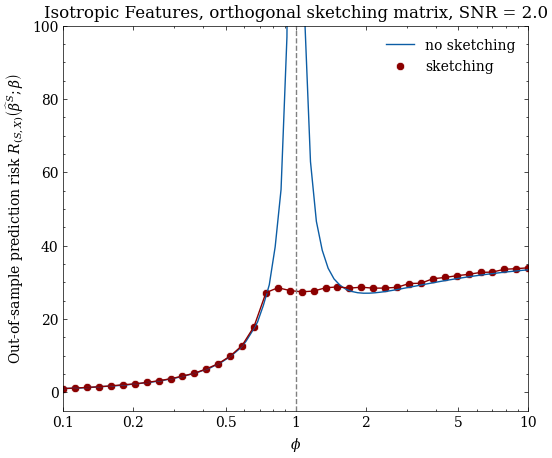

In [131]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    #ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk)
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_100.json')

    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', label="sketching")
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
    ax.set_ylim(-5, 100)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)

    ax.set_title("Isotropic Features, orthogonal sketching matrix, SNR = 2.0")
    ax.set_ylabel(r"Out-of-sample prediction risk $R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$")
    ax.set_xlabel(r"$\phi$")

    plt.savefig('figure6.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

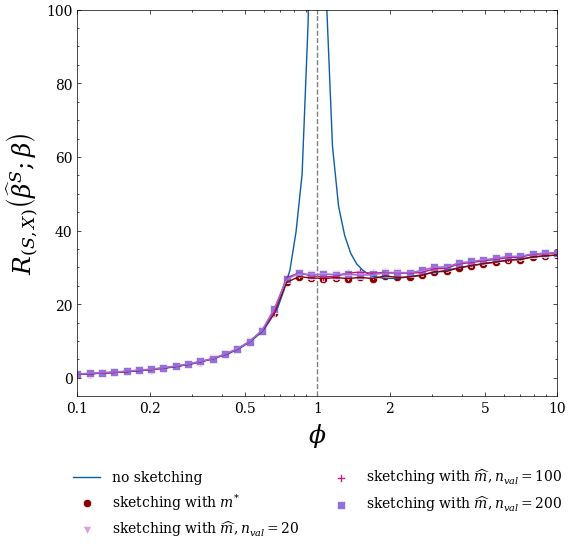

In [132]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_optimal_m.json')
    ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', label=r"sketching with ${m^{*}}$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_20.json')
    #ax = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='plum')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="v", color='plum', label=r"sketching with $\widehat{m}, n_{val}=20$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_100.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumvioletred')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="P", color='mediumvioletred', label=r"sketching with $\widehat{m}, n_{val}=100$")
    
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_200.json')
    ax = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple')
    ax = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple', marker="s", label=r"sketching with $\widehat{m}, n_{val}=200$")
    
    
    ax.set_ylim(-5, 100)
    ax.set_xlim(0.1, 10)
    ax.axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    #ax.set_title("Correlated features, orthogonal sketching matrix, SNR = 2.0")
    ax.set_xscale('log')
    ax.set(xticks = ticks, xticklabels = labels)
    #ax.legend(loc='lower right', prop={'size':9})
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor =(0.5, -0.4), ncol = 2, prop={'size':10})
    
    ax.set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax.set_xlabel(r"$\phi$", fontsize=18)
    
    
    plt.tight_layout()

    

    plt.savefig('figure6.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()

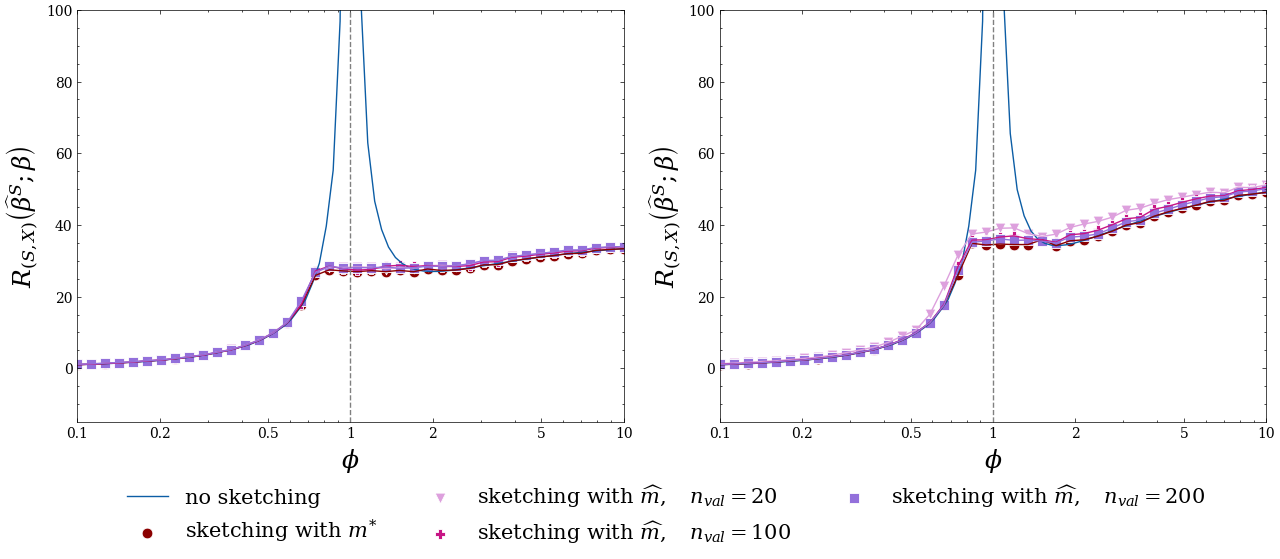

In [13]:
# Plot
ticks = [0.1, 0.2, 0.5, 1, 2, 5, 10]
labels = [i for i in ticks]

with plt.style.context(['science', 'no-latex', 'std-colors']):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_optimal_m.json')
    ax[0] = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching", ax=ax[0])
    ax[0] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred', ax=ax[0])
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', s=60, label=r"sketching with ${m^{*}}$", ax=ax[0])
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_20.json')
    ax[0] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='plum', ax=ax[0])
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="v", color='plum', s=60, label=r"sketching with $\widehat{m}, \quad n_{val}=20$", ax=ax[0])
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_100.json')
    ax[0] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumvioletred', ax=ax[0])
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="P", color='mediumvioletred', s=60, label=r"sketching with $\widehat{m}, \quad n_{val}=100$", ax=ax[0])
     
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('indep_practical_procedure/snr2.0_200.json')
    ax[0] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple', ax=ax[0])
    ax[0] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple', marker="s", s=60, label=r"sketching with $\widehat{m}, \quad n_{val}=200$", ax=ax[0])
    
    ax[0].set_ylim(-15, 100)
    ax[0].set_xlim(0.1, 10)
    ax[0].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[0].set_xscale('log')
    ax[0].set(xticks = ticks, xticklabels = labels)
    ax[0].legend(loc='lower right', prop={'size':9})
    
    ax[0].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[0].set_xlabel(r"$\phi$", fontsize=18)
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('thm4.2_sym_lambda_S_orthogonal/snr2.0.json')
    ax[1] = sns.lineplot(x=phi_asy, y=ridgeless_risk, label="no sketching")
    ax[1] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='darkred')
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='darkred', s=60, label=r"sketching with ${m^{*}}$")
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_20.json')
    ax[1] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='plum')
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="v", color='plum', s=60, label=r"sketching with $\widehat{m}, n_{val}=20$")
    
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_100.json')
    ax[1] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumvioletred')
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, marker="P", color='mediumvioletred', s=60, label=r"sketching with $\widehat{m}, n_{val}=100$")
     
    alpha, sigma, emp_phi, emp_sketch_risk, phi_asy, ridgeless_risk = load_files('practical_procedure/snr2.0_200.json')
    ax[1] = sns.lineplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple')
    ax[1] = sns.scatterplot(x=emp_phi, y=emp_sketch_risk, color='mediumpurple', marker="s", s=60, label=r"sketching with $\widehat{m}, n_{val}=200$")
    
    ax[1].set_ylim(-15, 100)
    ax[1].set_xlim(0.1, 10)
    ax[1].axvline(x=1, color="grey", linestyle='dashed', linewidth=1)
    ax[1].set_xscale('log')
    ax[1].set(xticks = ticks, xticklabels = labels)
    ax[1].legend(loc='lower right', prop={'size':9})    
    ax[1].set_ylabel(r"$R_{(S, X)}\left(\widehat{\beta}^S ; \beta\right)$", fontsize=18)
    ax[1].set_xlabel(r"$\phi$", fontsize=18)
    
    ax[0].get_legend().remove()
    ax[1].get_legend().remove()

    handles, labels = ax[0].get_legend_handles_labels()
 
    #handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.15), ncol = 3, prop={'size':15})
    plt.tight_layout()


    plt.savefig('figure6.pdf', dpi=400, facecolor='w', edgecolor='w', pad_inches=None)
    plt.show()